## Pandas or Bears?

In [2]:
#trying an alternative to check for local notebooks
import urllib.request
try:
    urllib.request.urlopen('https://www.google.com', timeout=2)
except Exception:
    raise Exception("STOP: No internet connection.")

In [4]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

## Step 1: Download images of Pandas and Bears

In [6]:
!pip install duckduckgo_search
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=200): 
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

Let's start by searching for a panda photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [9]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('panda photos', max_images=1)
urls[0]

C:\Users\srika\AppData\Local\Temp\ipykernel_12412\2641039908.py:6: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


'http://wallsdesk.com/wp-content/uploads/2016/12/Panda-Photos.jpg'

...and then download a URL and take a look at it:

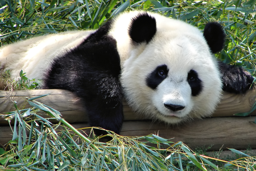

In [11]:
from fastdownload import download_url
dest = 'panda.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "cupcake photos":

C:\Users\srika\AppData\Local\Temp\ipykernel_12412\2641039908.py:6: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


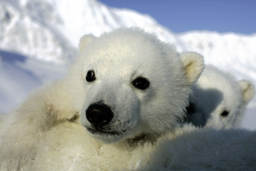

In [15]:
download_url(search_images('polar bear photos', max_images=1)[0], 'polar_bear.jpg', show_progress=False)
Image.open('polar_bear.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "panda" and "polar bear" photos, and save each group of photos to a different folder:

In [17]:
searches = 'panda','polar bear'
path = Path('panda_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

C:\Users\srika\AppData\Local\Temp\ipykernel_12412\2641039908.py:6: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
C:\Users\srika\AppData\Local\Temp\ipykernel_12412\2641039908.py:6: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [20]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

30

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

In [22]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

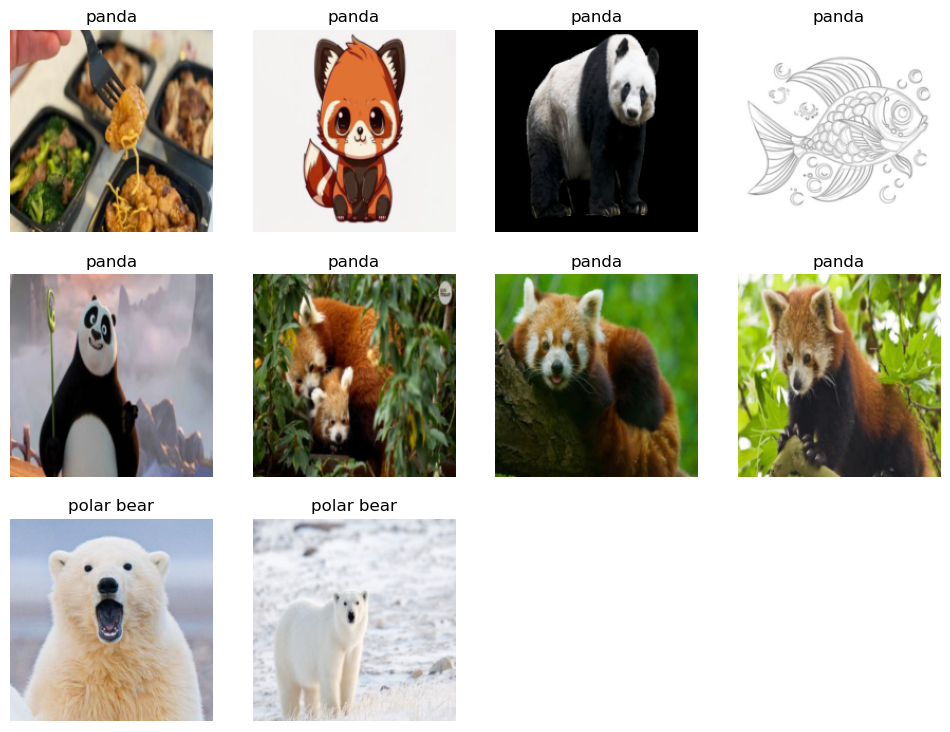

In [24]:
dls.show_batch(max_n=10)

In [26]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.643386,0.117390,0.030303,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.180279,0.090631,0.030303,00:18
1,0.153850,0.067759,0.045455,00:19
2,0.102760,0.043723,0.015152,00:18
3,0.079053,0.053192,0.045455,00:17
4,0.064054,0.055977,0.045455,00:19


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that panda we downloaded at the start:

In [28]:
is_panda,_,probs = learn.predict(PILImage.create('panda.jpg'))
print(f"This is a: {is_panda}.")
print(f"Probability it's a panda: {probs[0]:.4f}")

This is a: panda.
Probability it's a panda: 1.0000


In [30]:
is_panda,_,probs = learn.predict(PILImage.create('polar_bear.jpg'))
print(f"This is a: {is_panda}.")
print(f"Probability it's a panda: {probs[0]:.4f}")

This is a: polar bear.
Probability it's a panda: 0.0001
